In [1]:
import sys
import os
path = os.path.abspath("../../VecRepV3") 
sys.path.append(path)
print(path)

/home/jovyan/VecRepV3


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Sampler, random_split, Dataset
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd

from collections import defaultdict
from line_profiler import profile
from scipy.linalg import orthogonal_procrustes

import src.data_processing.BruteForceEstimator as bfEstimator
import src.data_processing.ImageCalculations as imgcalc
import src.visualization.ImagePlots as imgplt
import src.helpers.ModelUtilities as models

from functools import partial
from learnable_polyphase_sampling.learn_poly_sampling.layers import get_logits_model, PolyphaseInvariantDown2D, LPS
from learnable_polyphase_sampling.learn_poly_sampling.layers.polydown import set_pool

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  

/home/jovyan/miniconda3/envs/test/lib/python3.12/site-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


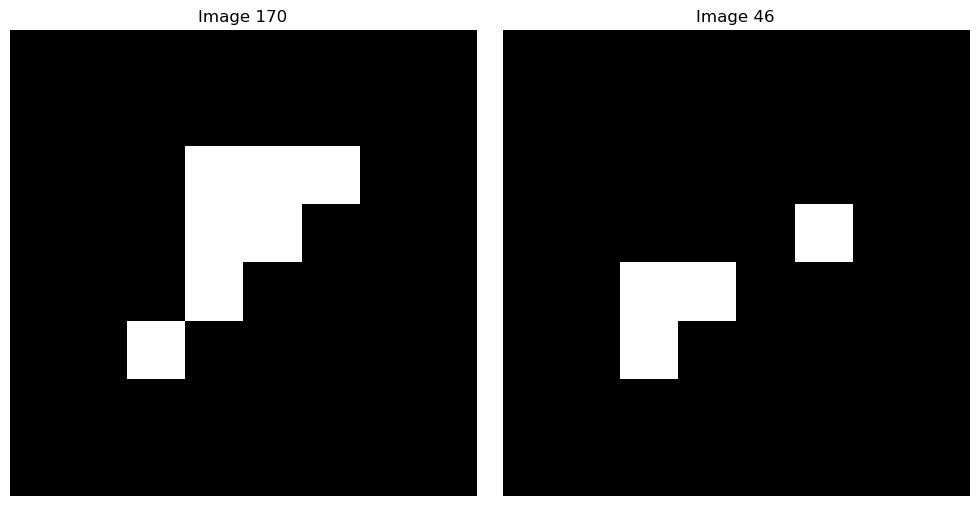

In [3]:
# ----------------------------------Image Input----------------------------------
IMAGE_TYPES = ["NbinMmax_ones", "Nbin", "triangles", "triangle_mean_subtracted"]

IMAGE_FILTERS = ["unique", "Nmax_ones", "one_island"]

IMAGE_PRODUCT_TYPES = ["ncc", "ncc_scaled"]

EMBEDDING_TYPES = ["pencorr_D"]

dimensions = 32

imageType = "triangles" #6x6 triangle in 12x12 matrix shapes_3_dims_6_3
filters = ["unique"]
imageProductType = "ncc_scaled_-1"
overwrite = {"imgSet": False, "imgProd": False, "embedding": False}
weight = None
embeddingType = f"pencorr_{dimensions}"
k=5

bruteForceEstimator = bfEstimator.BruteForceEstimator(
    imageType=imageType, filters=filters, imageProductType=imageProductType, embeddingType=embeddingType, overwrite=overwrite)

index1 = np.random.randint(len(bruteForceEstimator.imageSet))
index2 = np.random.randint(len(bruteForceEstimator.imageSet))

input1=bruteForceEstimator.imageSet[index1]
input2=bruteForceEstimator.imageSet[index2]

imgplt.plot_original_images(input1, input2, index1, index2)

# ------------------------- Preprocessing Dataset ------------------------
input_dataset = []
for img in bruteForceEstimator.imageSet:
    img_tensor = torch.from_numpy(np.array(img, dtype=np.float64))
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).cuda().double()
    input_dataset.append(img_tensor)
input_dataset = [tensor.float() for tensor in input_dataset] 

stacked_tensor = torch.stack(input_dataset)
input_dataset = stacked_tensor.cpu().numpy()      
input_dataset = [torch.tensor(data).cuda().float() for data in input_dataset]

In [4]:
# ----------------------------------Obtain unique images index from all 8x8 dataset----------------------------------
filters = ["100max_ones"]
bruteForceEstimator2 = bfEstimator.BruteForceEstimator(
    imageType=imageType, filters=filters, imageProductType=imageProductType, embeddingType=embeddingType, overwrite=overwrite)

unique_indices = []
for i in range(len(bruteForceEstimator.imageSet)):
    for j in range(len(bruteForceEstimator2.imageSet)):
        if np.array_equal(bruteForceEstimator.imageSet[i], bruteForceEstimator2.imageSet[j]):
            unique_indices.append(j)

In [5]:
model = models.SimpleCNN(dimensions=dimensions, padding_mode='circular').to(device)
model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), "model", 
                                               f"best_model_batch_greyscale_8bin_LPS_circular_{dimensions}d.pt")))
model.eval()
#----------------------Metric 1 - Loss Calculation-----------------
NCC_scaled_value = imgcalc.get_NCC_score(input1, input2)
print("\nLoss Calculation")
print("\nScaled NCC: ",NCC_scaled_value)

embedded_vector_image1 = model(input_dataset[index1])
embedded_vector_image2 = model(input_dataset[index2])

dot_product_value = imgcalc.get_dp_score(embedded_vector_image1, embedded_vector_image2)

print("Dot product value of model: ", dot_product_value.item())

train_loss_value = imgcalc.get_loss_value(dot_product_value, NCC_scaled_value) 
print("Loss: ", train_loss_value)

matrixA = bruteForceEstimator.matrixA
matrixG = bruteForceEstimator.matrixG
dot_product_matrix = np.dot(matrixA.T, matrixA)
dot_product_value_Pencorr = dot_product_matrix[index1][index2]
difference = abs(dot_product_value_Pencorr - dot_product_value)

print("\nDot product value of BF Method: ", dot_product_value_Pencorr)

train_loss_value = imgcalc.get_loss_value(torch.tensor(dot_product_value_Pencorr), NCC_scaled_value) 
print("Loss: ", train_loss_value)
print("Difference in values of BF Method and Model Method: ", difference.item())

/tmp/ipykernel_17498/1303578095.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), "model",


Loss Calculation

Scaled NCC:  0.13389348983764648
Dot product value of model:  0.348774790763855
Loss:  0.2148813009262085

Dot product value of BF Method:  0.17595913566319443
Loss:  0.04206565022468567
Difference in values of BF Method and Model Method:  0.17281565070152283


----------------
Brute Force Method -- KNN-IOU score
----------------
Estimating K-Score for Image 170: K-Score = 0.75
Intersection sets : [ 77  92  93 126 169 170]
Union sets: [ 77  92  93 126 164 169 170 180]

Top 8 values of Vector b
Rank 1: Value = 1.0, Index = 170
Rank 2: Value = 0.8516402244567871, Index = 77
Rank 3: Value = 0.7142858505249023, Index = 92
Rank 4: Value = 0.7142858505249023, Index = 93
Rank 5: Value = 0.7142858505249023, Index = 126
Rank 6: Value = 0.7142858505249023, Index = 164
Rank 7: Value = 0.7142858505249023, Index = 169
Rank 8: Value = 0.7142858505249023, Index = 180

Top 8 values of Vector c
Rank 1: Value = 0.9999999999999998, Index = 170
Rank 2: Value = 0.8656732520623038, Index = 77
Rank 3: Value = 0.8331530740994797, Index = 169
Rank 4: Value = 0.7417583101875044, Index = 126
Rank 5: Value = 0.7057356513887262, Index = 92
Rank 6: Value = 0.6997669935782442, Index = 93
Rank 7: Value = 0.6966058164910961, Index = 180
Rank 8: Value = 0.692732642950808, Ind

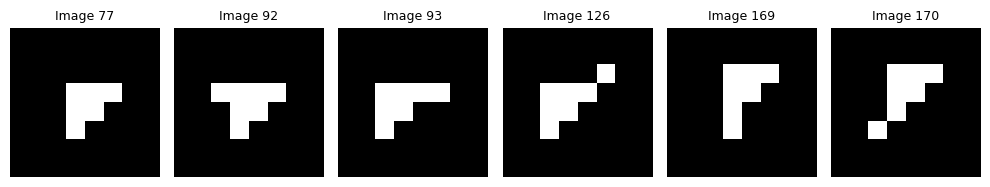


Plotting images in the union set:


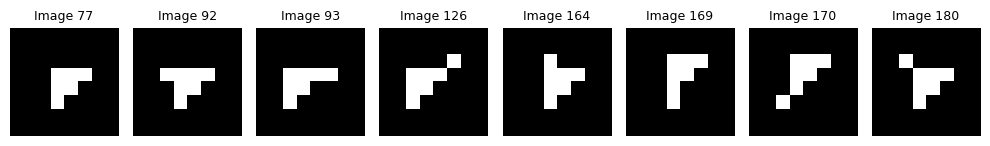


For translationally unique plots: 
Image 77 has no translationally similar images.
Image 92 has no translationally similar images.
Image 93 has no translationally similar images.
Image 126 has no translationally similar images.
Image 164 has no translationally similar images.
Image 169 has no translationally similar images.
Image 170 has no translationally similar images.
Image 180 has no translationally similar images.

Plotting images in the intersection set:


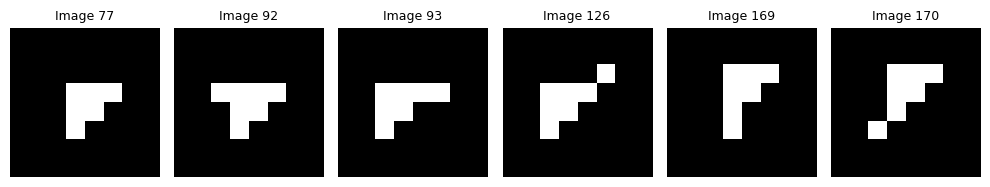


Plotting images in the union set:


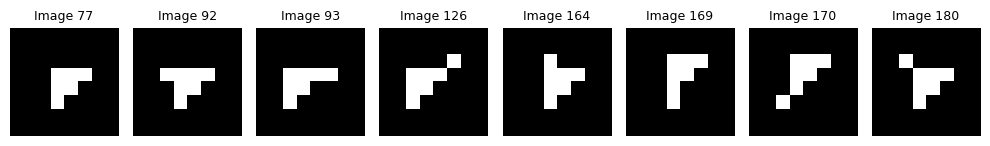

Estimating K-Score for Image 46: K-Score = 0.5
Intersection sets : [ 3 10 42 46]
Union sets: [  3  10  42  44  46  93 126 146]

Top 8 values of Vector b
Rank 1: Value = 1.0, Index = 46
Rank 2: Value = 0.732050895690918, Index = 3
Rank 3: Value = 0.732050895690918, Index = 10
Rank 4: Value = 0.732050895690918, Index = 42
Rank 5: Value = 0.5118579864501953, Index = 93
Rank 6: Value = 0.5118579864501953, Index = 126
Rank 7: Value = 0.5, Index = 4
Rank 8: Value = 0.5, Index = 18

Top 8 values of Vector c
Rank 1: Value = 1.0, Index = 46
Rank 2: Value = 0.7834441652644599, Index = 10
Rank 3: Value = 0.5643128702924542, Index = 146
Rank 4: Value = 0.5484791491567373, Index = 44
Rank 5: Value = 0.5341024638740205, Index = 3
Rank 6: Value = 0.4980331003615076, Index = 42
Rank 7: Value = 0.497534830929384, Index = 66
Rank 8: Value = 0.4916674879222575, Index = 19

Comparison between vector c and vector b
 Index  Vector b Value (NCC value)  Vector c Value (Dot product value)
    46               

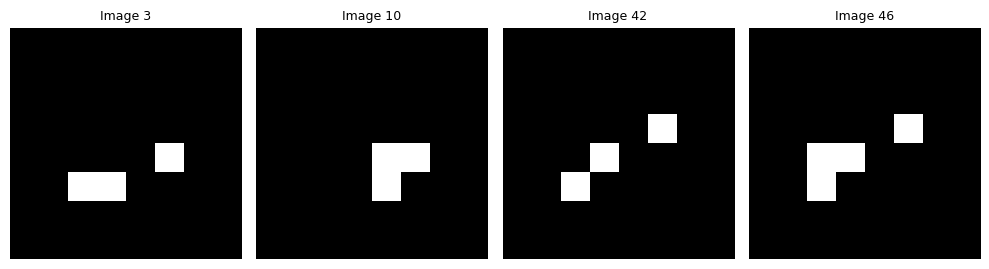


Plotting images in the union set:


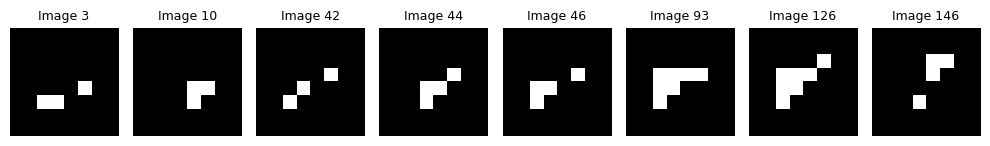


For translationally unique plots: 
Image 3 has no translationally similar images.
Image 10 has no translationally similar images.
Image 42 has no translationally similar images.
Image 44 has no translationally similar images.
Image 46 has no translationally similar images.
Image 93 has no translationally similar images.
Image 126 has no translationally similar images.
Image 146 has no translationally similar images.

Plotting images in the intersection set:


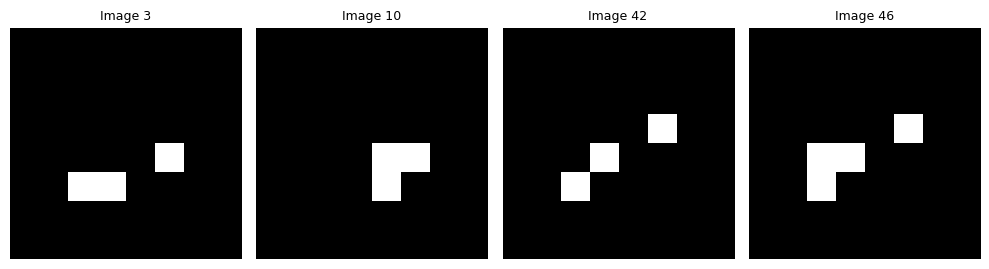


Plotting images in the union set:


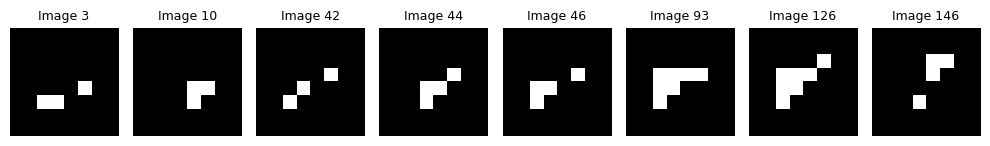

----------------
Model Method -- KNN-IOU score
----------------
Estimating K-Score for Image 170: K-Score = 0.75
Intersection sets : [ 77  92  93 126 170 180]
Union sets: [ 77  92  93 126 164 169 170 180]

Top 8 values of Vector b
Rank 1: Value = 1.0, Index = 170
Rank 2: Value = 0.8516402244567871, Index = 77
Rank 3: Value = 0.7142858505249023, Index = 92
Rank 4: Value = 0.7142858505249023, Index = 93
Rank 5: Value = 0.7142858505249023, Index = 126
Rank 6: Value = 0.7142858505249023, Index = 164
Rank 7: Value = 0.7142858505249023, Index = 169
Rank 8: Value = 0.7142858505249023, Index = 180

Top 8 values of Vector c
Rank 1: Value = 1.0, Index = 170
Rank 2: Value = 0.8808242082595825, Index = 77
Rank 3: Value = 0.8262090682983398, Index = 126
Rank 4: Value = 0.8202509880065918, Index = 180
Rank 5: Value = 0.7632281184196472, Index = 93
Rank 6: Value = 0.7553257346153259, Index = 92
Rank 7: Value = 0.7298024892807007, Index = 169
Rank 8: Value = 0.7262743711471558, Index = 164

Comparison

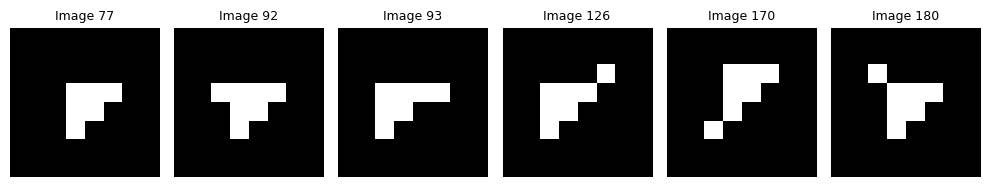


Plotting images in the union set:


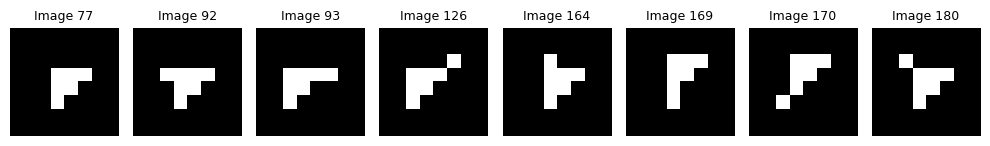


For translationally unique plots: 
Image 77 has no translationally similar images.
Image 92 has no translationally similar images.
Image 93 has no translationally similar images.
Image 126 has no translationally similar images.
Image 164 has no translationally similar images.
Image 169 has no translationally similar images.
Image 170 has no translationally similar images.
Image 180 has no translationally similar images.

Plotting images in the intersection set:


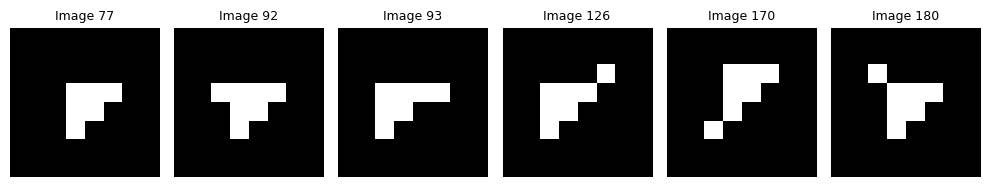


Plotting images in the union set:


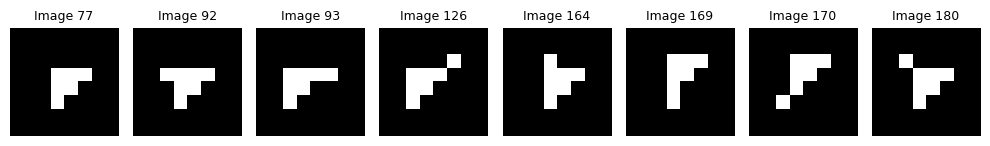

Estimating K-Score for Image 46: K-Score = 0.2
Intersection sets : [10 46]
Union sets: [  3  10  42  44  46  66  93 126 146 173]

Top 10 values of Vector b
Rank 1: Value = 1.0, Index = 46
Rank 2: Value = 0.732050895690918, Index = 3
Rank 3: Value = 0.732050895690918, Index = 10
Rank 4: Value = 0.732050895690918, Index = 42
Rank 5: Value = 0.5118579864501953, Index = 93
Rank 6: Value = 0.5118579864501953, Index = 126
Rank 7: Value = 0.5, Index = 4
Rank 8: Value = 0.5, Index = 18
Rank 9: Value = 0.5, Index = 19
Rank 10: Value = 0.5, Index = 44

Top 10 values of Vector c
Rank 1: Value = 1.0, Index = 46
Rank 2: Value = 0.8393728733062744, Index = 146
Rank 3: Value = 0.7508530616760254, Index = 44
Rank 4: Value = 0.7318840622901917, Index = 66
Rank 5: Value = 0.7243965268135071, Index = 10
Rank 6: Value = 0.6854785680770874, Index = 173
Rank 7: Value = 0.6221519708633423, Index = 112
Rank 8: Value = 0.6053586006164551, Index = 84
Rank 9: Value = 0.571029543876648, Index = 18
Rank 10: Value 

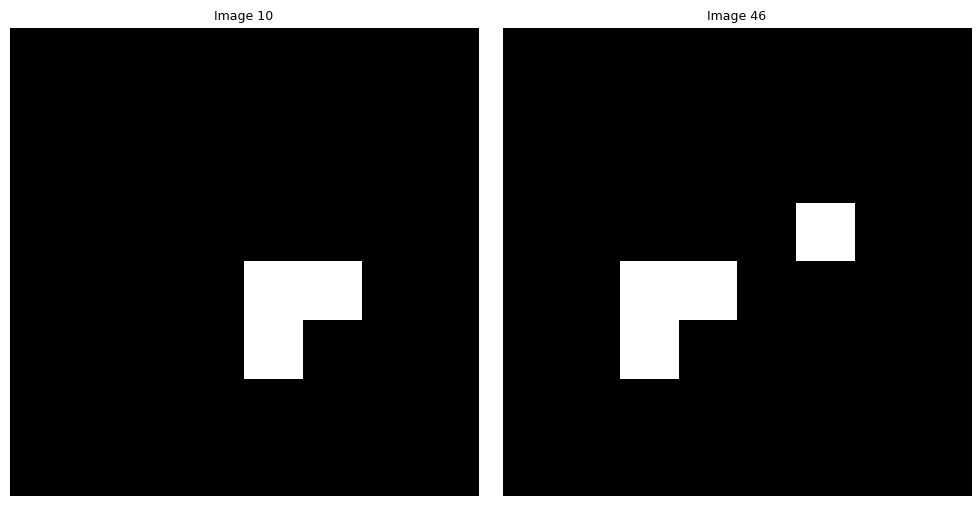


Plotting images in the union set:


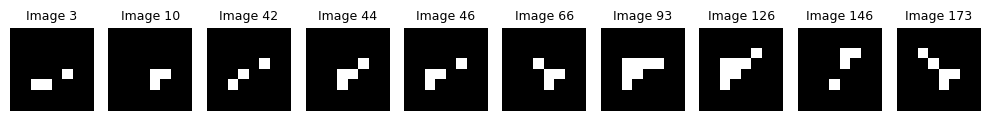


For translationally unique plots: 
Image 3 has no translationally similar images.
Image 10 has no translationally similar images.
Image 42 has no translationally similar images.
Image 44 has no translationally similar images.
Image 46 has no translationally similar images.
Image 66 has no translationally similar images.
Image 93 has no translationally similar images.
Image 126 has no translationally similar images.
Image 146 has no translationally similar images.
Image 173 has no translationally similar images.

Plotting images in the intersection set:


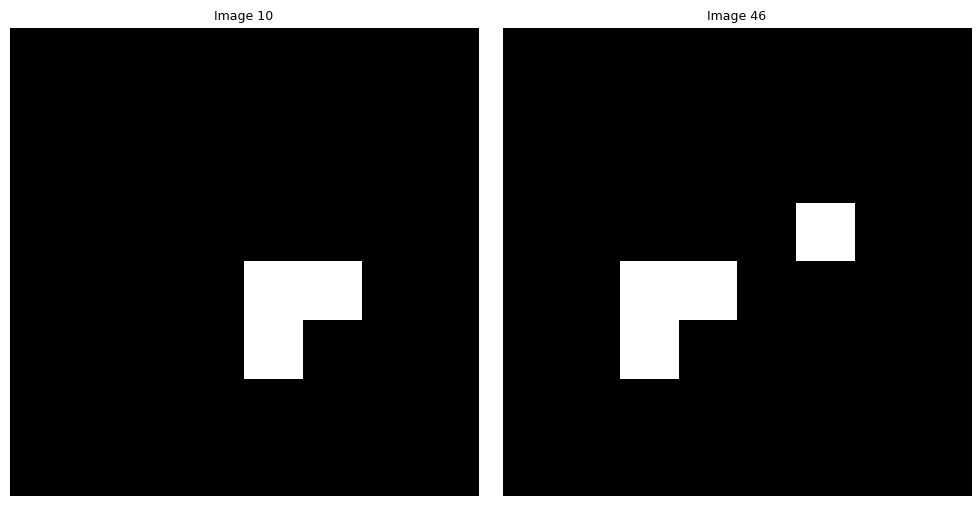


Plotting images in the union set:


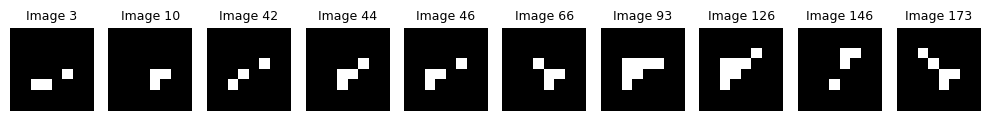

In [6]:
#----------------------Metric 2 - KNNIoU-----------------
print("----------------\nBrute Force Method -- KNN-IOU score\n----------------")
vectorb_bf1 = bruteForceEstimator.matrixG[index1]
vectorc_bf1 = imgcalc.get_vectorc_brute(index1, bruteForceEstimator.matrixA)
imgplt.display_and_plot_results(vectorb_bf1, vectorc_bf1, "Brute Force", index1, k, bruteForceEstimator.imageSet)

vectorb_bf2 = bruteForceEstimator.matrixG[index2]
vectorc_bf2 = imgcalc.get_vectorc_brute(index2, bruteForceEstimator.matrixA)
imgplt.display_and_plot_results(vectorb_bf2, vectorc_bf2, "Brute Force", index2, k, bruteForceEstimator.imageSet)

print("----------------\nModel Method -- KNN-IOU score\n----------------")
vectorb_model1 = bruteForceEstimator.matrixG[index1]
vectorc_model1 = imgcalc.get_vectorc_model(index1, model, input_dataset)
imgplt.display_and_plot_results(vectorb_model1, vectorc_model1, "Model", index1, k, bruteForceEstimator.imageSet)

vectorb_model2 = bruteForceEstimator.matrixG[index2]
vectorc_model2 = imgcalc.get_vectorc_model(index2, model, input_dataset)
imgplt.display_and_plot_results(vectorb_model2, vectorc_model2, "Model", index2, k, bruteForceEstimator.imageSet)

K-Score for index 0 is 0.3333333333333333
Average loss for index 0 is 0.18313956421722347
K-Score for index 1 is 0.3333333333333333
Average loss for index 1 is 0.25640841053488356
K-Score for index 2 is 0.7142857142857143
Average loss for index 2 is 0.16184078637161292
K-Score for index 3 is 0.2
Average loss for index 3 is 0.27037874129018746
K-Score for index 4 is 0.5
Average loss for index 4 is 0.22337925676644468
K-Score for index 5 is 0.3333333333333333
Average loss for index 5 is 0.1579547610017471
K-Score for index 6 is 0.5
Average loss for index 6 is 0.19049006023366624
K-Score for index 7 is 0.7142857142857143
Average loss for index 7 is 0.1585788776477178
K-Score for index 8 is 0.3333333333333333
Average loss for index 8 is 0.14928564559280252
K-Score for index 9 is 0.5
Average loss for index 9 is 0.22178091366852945
K-Score for index 10 is 0.3333333333333333
Average loss for index 10 is 0.20374008601841828
K-Score for index 11 is 0.5
Average loss for index 11 is 0.23317167913

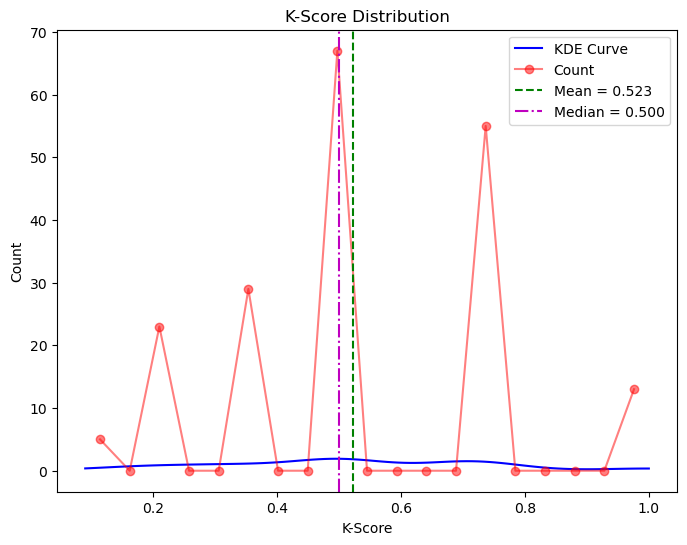

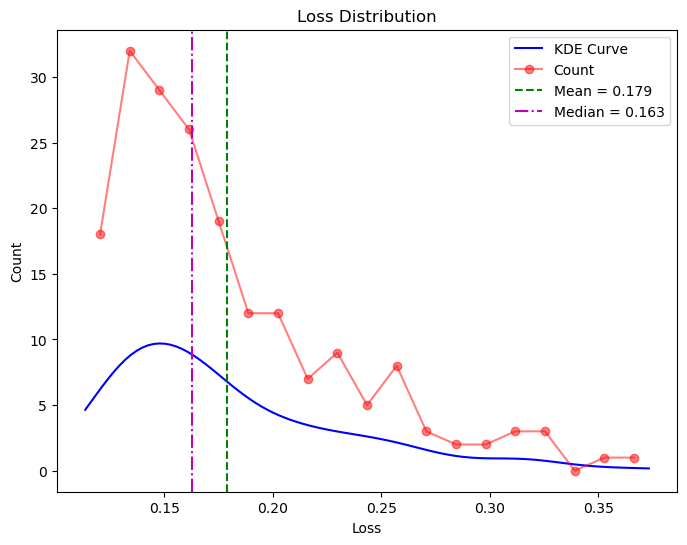

In [7]:
#--------------------Visualisation across test dataset using circular padding-------------------
kscores, losses, ncc_loss_dict = imgcalc.kscore_loss_evaluation(bruteForceEstimator.imageSet, input_dataset, model, k)

imgcalc.loss_per_ncc_score(ncc_loss_dict)
imgplt.plot_score_distribution(kscores, "K-Score")
imgplt.plot_score_distribution(losses, "Loss")

K-Score for index 0 is 0.3333333333333333
Average loss for index 0 is 0.15157479104042673
K-Score for index 1 is 0.5
Average loss for index 1 is 0.19377315193802738
K-Score for index 2 is 0.5
Average loss for index 2 is 0.12330529988200094
K-Score for index 3 is 0.2
Average loss for index 3 is 0.18734242528444156
K-Score for index 4 is 0.7142857142857143
Average loss for index 4 is 0.15569679202356687
K-Score for index 5 is 0.3333333333333333
Average loss for index 5 is 0.13044535222191675
K-Score for index 6 is 0.2
Average loss for index 6 is 0.16931721248935597
K-Score for index 7 is 1.0
Average loss for index 7 is 0.12504912138683721
K-Score for index 8 is 0.3333333333333333
Average loss for index 8 is 0.12666420317448987
K-Score for index 9 is 0.3333333333333333
Average loss for index 9 is 0.13183418408152647
K-Score for index 10 is 0.5
Average loss for index 10 is 0.16328630588638285
K-Score for index 11 is 0.7142857142857143
Average loss for index 11 is 0.17454366658542617
K-Scor

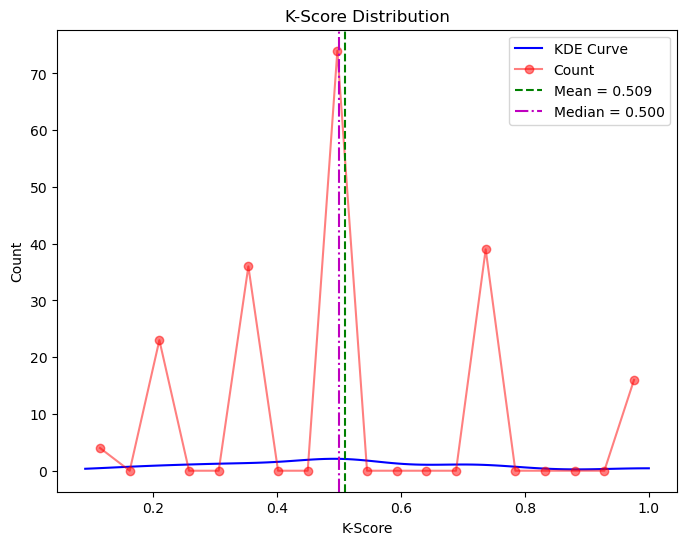

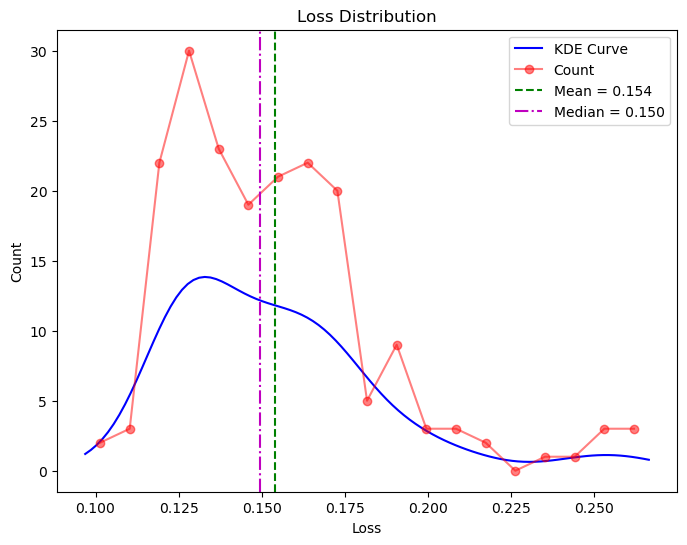

In [8]:
#--------------------Visualisation across test dataset using zeros padding-------------------
kscores, losses, ncc_loss_dict = imgcalc.kscore_loss_evaluation(bruteForceEstimator.imageSet, input_dataset, modelz, k)

imgcalc.loss_per_ncc_score(ncc_loss_dict)
imgplt.plot_score_distribution(kscores, "K-Score")
imgplt.plot_score_distribution(losses, "Loss")

In [7]:
# -----------------------------Before transforming output embedding matrices-----------------------------
# ----------- Preprocessing dataset -------------
matrixG = bruteForceEstimator.matrixG
matrixA_complete = bruteForceEstimator2.matrixA

matrixA_full = bruteForceEstimator.matrixA
matrixA = matrixA_complete[:, unique_indices]
dot_product_matrix = np.dot(matrixA.T, matrixA)

print(f"Difference between matrices")
mean_squared_difference = imgcalc.get_MSE(matrixA_full, matrixA)
print("\nMean Squared Difference of A from unique dataset and subsetted A from full dataset:", mean_squared_difference)

mean_squared_difference = imgcalc.get_MSE(matrixG, dot_product_matrix)
print("Mean Squared Difference of Pencorr (A'A) and NCC (G):", mean_squared_difference)

model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
model_matrix = imgcalc.get_matrix_embeddings(input_dataset, model_vectors)
        
mean_squared_difference = imgcalc.get_MSE(matrixG, model_matrix.detach().cpu().numpy())
print("\nMean Squared Difference of Model and NCC (G):", mean_squared_difference)
        
mean_squared_difference = imgcalc.get_MSE(dot_product_matrix, model_matrix.detach().cpu().numpy())
print("Mean Squared Difference of Model and Pencorr (A'A):", mean_squared_difference)
    
print(f"\nPrinting matrices")
print(f"\nMatrix G: {matrixG}")
print(f"\nMatrix A'A (Pencorr): {dot_product_matrix}, {dot_product_matrix.shape}")
print(f"\nMatrix A'A (Model): {model_matrix.detach().cpu().numpy()}, {model_matrix.detach().cpu().numpy().shape}")

print(f"\nPrinting vectors")
print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]}")
print(f"Embedding of image {index1} for Model: {model_vectors[index1]}")

print(f"\nDifferences between vector embeddings")
mean_squared_difference = imgcalc.get_MSE(matrixA[:,index1], model_vectors[index1].detach().cpu().numpy())
print(f"Mean Squared Difference of Pencorr (A) and Model: {mean_squared_difference}")

Difference between matrices

Mean Squared Difference of A from unique dataset and subsetted A from full dataset: 0.08025201870295606
Mean Squared Difference of Pencorr (A'A) and NCC (G): 0.006987865815848696

Mean Squared Difference of Model and NCC (G): 0.05457234355934607
Mean Squared Difference of Model and Pencorr (A'A): 0.04425675904388637

Printing matrices

Matrix G: [[1.         0.33333337 0.7320509  ... 0.22474492 0.09544504 0.09544504]
 [0.33333337 1.         0.7320509  ... 0.22474492 0.09544504 0.09544504]
 [0.7320509  0.7320509  1.         ... 0.06066024 0.26491106 0.26491106]
 ...
 [0.22474492 0.22474492 0.06066024 ... 1.         0.34164071 0.56524754]
 [0.09544504 0.09544504 0.26491106 ... 0.34164071 1.         0.39999998]
 [0.09544504 0.09544504 0.26491106 ... 0.56524754 0.39999998 1.        ]]

Matrix A'A (Pencorr): [[1.         0.30299255 0.65682802 ... 0.15212681 0.10879758 0.12010108]
 [0.30299255 1.         0.55973538 ... 0.18418044 0.07907408 0.14938274]
 [0.656828

In [8]:
#-----------------After transforming output embedding matrices via Orthorgonal Procrustes ----------------
print(f"Difference between matrices")
model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
model_transformed, error_model = imgcalc.get_orthogonal_transformation(model_vectors, matrixA) #transposed
model_transformed = [torch.tensor(row, dtype=torch.float32, device="cuda").unsqueeze(0).requires_grad_() for row in model_transformed]
model_matrix_transformed = imgcalc.get_matrix_embeddings(input_dataset, model_transformed)

mean_squared_difference = imgcalc.get_MSE(matrixG, model_matrix_transformed.detach().cpu().numpy())
print("\nMean Squared Difference of Model and NCC (G):", mean_squared_difference)
        
mean_squared_difference = imgcalc.get_MSE(dot_product_matrix, model_matrix_transformed.detach().cpu().numpy())
print("Mean Squared Difference of Model and Pencorr (A'A):", mean_squared_difference)
     

print(f"\nPrinting matrices after transformation")
print(f"\nMatrix G: {matrixG}")
print(f"\nMatrix A'A (Pencorr): {dot_product_matrix}, {dot_product_matrix.shape}")
print(f"\nMatrix A'A (Model): {model_matrix_transformed}, error: {error_model}")

print(f"\nPrinting vectors ")
print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]}")
print(f"Embedding of image {index1} for Model: {model_transformed[index1]}")

print(f"\nDifferences between vector embeddings")
mean_squared_difference = imgcalc.get_MSE(matrixA[:,index1], model_transformed[index1].detach().cpu().numpy())
print(f"Mean Squared Difference of Pencorr (A) and Model: {mean_squared_difference}")

Difference between matrices

Mean Squared Difference of Model and NCC (G): 0.11472823169543184
Mean Squared Difference of Model and Pencorr (A'A): 0.10772733325796985

Printing matrices after transformation

Matrix G: [[1.         0.33333337 0.7320509  ... 0.22474492 0.09544504 0.09544504]
 [0.33333337 1.         0.7320509  ... 0.22474492 0.09544504 0.09544504]
 [0.7320509  0.7320509  1.         ... 0.06066024 0.26491106 0.26491106]
 ...
 [0.22474492 0.22474492 0.06066024 ... 1.         0.34164071 0.56524754]
 [0.09544504 0.09544504 0.26491106 ... 0.34164071 1.         0.39999998]
 [0.09544504 0.09544504 0.26491106 ... 0.56524754 0.39999998 1.        ]]

Matrix A'A (Pencorr): [[1.         0.30299255 0.65682802 ... 0.15212681 0.10879758 0.12010108]
 [0.30299255 1.         0.55973538 ... 0.18418044 0.07907408 0.14938274]
 [0.65682802 0.55973538 1.         ... 0.13132032 0.22394484 0.14064857]
 ...
 [0.15212681 0.18418044 0.13132032 ... 1.         0.35808413 0.64704996]
 [0.10879758 0.079


MSE between vector embeddings of Pencorr (A) and Model (Circular padding):


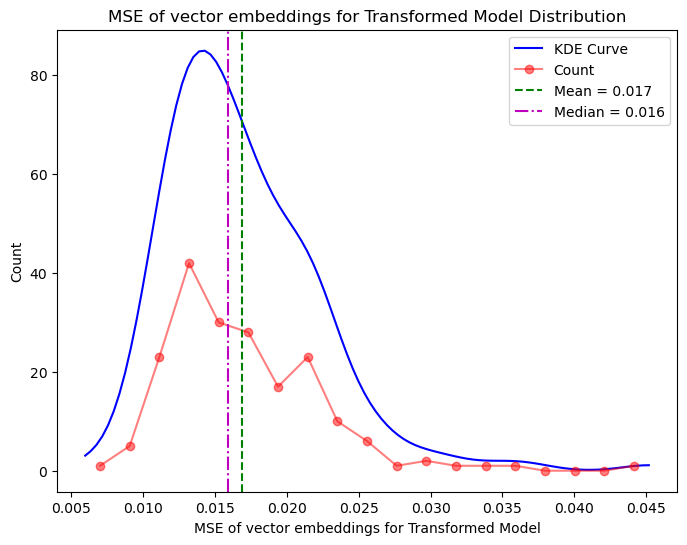

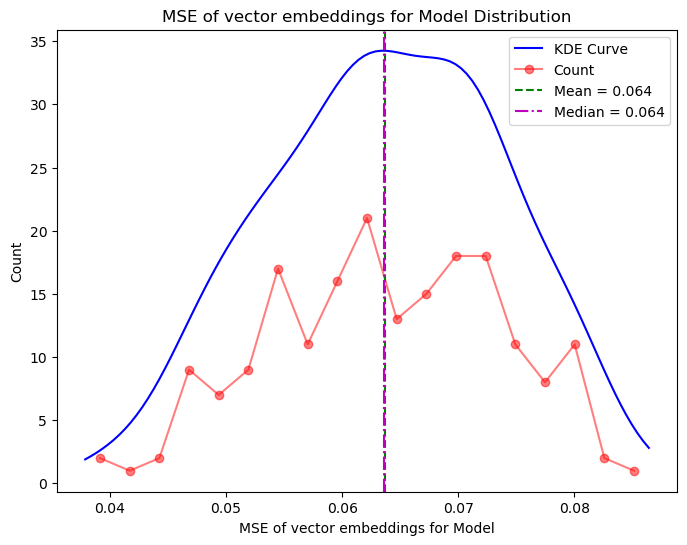

In [10]:
# ------------------------ MSE of embedding across dataset -----------------------------
num = len(input_dataset)
MSE_transformed = []
MSE_original = []
print(f"\nMSE between vector embeddings of Pencorr (A) and Model:")   
for i in range(num):
    difference_squared = (matrixA[:,i] - model_transformed[i].detach().cpu().numpy()) ** 2
    mean_squared_difference = np.sum(difference_squared) / difference_squared.size
    #print(f"Transformed matrix of Index {i}: {mean_squared_difference}")
    MSE_transformed.append(mean_squared_difference)
    difference_squared = (matrixA[:,i] - model_vectors[i].detach().cpu().numpy()) ** 2
    mean_squared_difference = np.sum(difference_squared) / difference_squared.size
    #print(f"Original matrix of Index {i}: {mean_squared_difference}")
    MSE_original.append(mean_squared_difference)
    
imgplt.plot_score_distribution(MSE_transformed, "MSE of vector embeddings for Transformed Model")
imgplt.plot_score_distribution(MSE_original, "MSE of vector embeddings for Model")

In [12]:
# ---------------------- Sanity check for embeddings of translationally similar images ----------------
modelz = models.SimpleCNN(dimensions=dimensions, padding_mode='zeros').to(device)
modelz.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), "model", 
                                               "best_model_batch_greyscale_8bin_LPS_zeros_32d.pt")))
modelz.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelz.to(device)

embedded_vector_image1 = modelz(input_dataset[index1])
input2 = img_roll = torch.roll(input_dataset[index1],shifts=(1, 1), dims=(-1, -2))
embedded_vector_image2 = modelz(input2)

print("Zero padding\nvector1: ", embedded_vector_image1)
print("vector2: ", embedded_vector_image2)
# ------------------------------------------------------------------------------------------
model = models.SimpleCNN(dimensions=dimensions, padding_mode='circular').cuda()
model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), "model", 
                                               "best_model_batch_greyscale_8bin_LPS_circular_32d.pt")))
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

embedded_vector_image1 = model(input_dataset[index1])
input2 = img_roll = torch.roll(input_dataset[index1],shifts=(1, 1), dims=(-1, -2))
embedded_vector_image2 = model(input2)

print("\nCircular padding\nvector1: ", embedded_vector_image1)
print("vector2: ", embedded_vector_image2)

print("\nMatrix A Vector: ", matrixA[:, 0])

Zero padding
vector1:  tensor([[ 0.1917, -0.3262,  0.0774, -0.0683,  0.0426, -0.0140,  0.1252, -0.2028,
         -0.2588,  0.3305,  0.1143,  0.0486,  0.2010,  0.1303, -0.3411,  0.2457,
          0.0816,  0.1184,  0.2420,  0.3519, -0.0109, -0.0913, -0.0126, -0.0897,
         -0.1403,  0.0741,  0.0203,  0.1090, -0.1476, -0.1227, -0.2594,  0.0150]],
       device='cuda:0', grad_fn=<DivBackward0>)
vector2:  tensor([[ 0.1777, -0.3548,  0.3664, -0.0565,  0.1429, -0.0798,  0.0979, -0.1611,
         -0.0169,  0.2024, -0.0671, -0.0363,  0.2051,  0.0835, -0.3654,  0.3164,
          0.1454,  0.1782,  0.1494,  0.2734, -0.0233, -0.2320,  0.0395,  0.0597,
         -0.1349,  0.0113,  0.0218,  0.1767, -0.0766, -0.0495, -0.2080,  0.0438]],
       device='cuda:0', grad_fn=<DivBackward0>)

Circular padding
vector1:  tensor([[ 0.0449,  0.1847,  0.0412,  0.0842,  0.1268, -0.2423,  0.2624, -0.4320,
          0.1881,  0.2214, -0.2998, -0.0673,  0.0880,  0.2154,  0.0308,  0.3352,
         -0.0287,  0.2174, -0